<div style="float:left">
            <h1 style="width:900px">“Sharing” or “Occupying”? Investigation on Hotel-like Airbnb Listings and Their Hosts in London</h1>
            <h2 style="width:900px">CASA0013: Introduction to Programming for Spatial Analysts</h2>
            <h3 style="width:450px">Student ID: 19175131</h3>
            <h3 style="width:450px">Word Count: 2472</h3>
</div>

# Executive Summary

***Key Findings:*** 
1. Airbnb acquiesces in the existence of hotel runners, who violate the "sharing economy" principle and aggravated the housing shortage. 
2. Airbnb makes real home-sharers less competitive and profitable than hosts with multiple listings.
3. Airbnb's hotel business phenomenon is more serious on the west of City of London in Inner London  

***Recommendation:*** 

The government should introduce more compulsory policies and regulations to Airbnb potential hotel runners in order to offer a fairer short-term rental market for real home-sharers.

# Reproducible Analysis

In [4]:
# read the data and take a look at the shape
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt
import mapclassify as mc
import pysal as p
import palettable.matplotlib as palmpl
from legendgram import legendgram

In [5]:
url = 'https://github.com/LingruFeng/i2p_assessment3/raw/main/listings_11_6.csv.gz'
df = pd.read_csv(url, compression='gzip', low_memory=False)
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Data frame is 76,984 x 74


## Data Selecting and Cleaning

Drop useless columns

In [6]:
drop_column=['bathrooms','neighbourhood_group_cleansed','calendar_updated','license','description','host_location',
             'scrape_id','neighborhood_overview','picture_url','host_url','host_about','host_listings_count',
             'host_total_listings_count','host_since','host_response_time','host_acceptance_rate','host_acceptance_rate',
             'host_verifications','host_has_profile_pic','host_identity_verified','neighbourhood','accommodates',
             'bathrooms_text','bedrooms','beds','minimum_nights','maximum_nights','minimum_minimum_nights',
             'maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
             'maximum_nights_avg_ntm','has_availability','availability_30','availability_60','availability_90',
             'number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d','review_scores_rating','host_response_rate',
             'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication',
             'review_scores_location','review_scores_value','instant_bookable','reviews_per_month','host_neighbourhood',
            'host_thumbnail_url','host_picture_url','amenities','calendar_last_scraped','first_review','last_review']
df.drop(columns=drop_column, axis=1,inplace=True)
df.shape

(76984, 18)

Drop the problematic Listings that fall out of the London boundary.

In [7]:
df=df.drop(index=(df.loc[(df.id==19723786)].index))
df=df.drop(index=(df.loc[(df['id']==31312542)].index))
df=df.drop(index=(df.loc[(df['id']==45878915)].index))
df=df.drop(index=(df.loc[(df['id']==45972733)].index))
df=df.drop(index=(df.loc[(df['id']==15863189)].index))
df=df.drop(index=(df.loc[(df['id']==19027695)].index))
df.shape

(76978, 18)

In [5]:
# The data was scraped on 2020-11-06 and 2020-11-07
df_test=df.drop_duplicates(subset='last_scraped')
df_test['last_scraped']

0    2020-11-07
3    2020-11-06
Name: last_scraped, dtype: object

In [8]:
# data converting
fn = url.split('/')[-1]
bools = ['host_is_superhost']
map = {'f':None}
for b in bools:
    print(f"Converting {b}")
    df[b] = df[b].replace(map).astype('bool')
dates = ['last_scraped']
for d in dates:
    print("Converting " + d)
    df[d] = pd.to_datetime(df[d], infer_datetime_format=True)
cats = ['property_type','room_type']
for c in cats:
    print(f"Converting {c}")
    df[c] = df[c].astype("category")
money = ['price']
df.sample(5, random_state=42)[money]
for m in money:
    print(f"Converting {m}")
    df[m] = df[m].str.replace('$','').str.replace(',','').astype('float')
ints  = ['id','host_id','availability_365','calculated_host_listings_count','calculated_host_listings_count_entire_homes',
        'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms']
for i in ints:
    print(f"Converting {i}")
    try:
        df[i] = df[i].astype('float').astype('int')
    except ValueError as e:
        print("\tConverting to unsigned 16-bit integer.")
        df[i] = df[i].astype('float').astype(pd.UInt16Dtype())
path = os.path.join('data','clean')

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
df.to_csv(os.path.join(path,fn), index=False)
print("Done.")

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
df.to_csv(os.path.join(path,fn), index=False)
print("Done.")

Converting host_is_superhost
Converting last_scraped
Converting property_type
Converting room_type
Converting price
Converting id
Converting host_id
Converting availability_365
Converting calculated_host_listings_count
Converting calculated_host_listings_count_entire_homes
Converting calculated_host_listings_count_private_rooms
Converting calculated_host_listings_count_shared_rooms
Creating data/clean under /home/jovyan/work/i2p_assessment_3
Done.
Done.


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76978 entries, 0 to 76983
Data columns (total 18 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            76978 non-null  int64         
 1   listing_url                                   76978 non-null  object        
 2   last_scraped                                  76978 non-null  datetime64[ns]
 3   name                                          76955 non-null  object        
 4   host_id                                       76978 non-null  int64         
 5   host_name                                     76967 non-null  object        
 6   host_is_superhost                             76978 non-null  bool          
 7   neighbourhood_cleansed                        76978 non-null  object        
 8   latitude                                      76978 non-null  floa

There are four types of room type.

In [8]:
df_test1=df.drop_duplicates(subset='room_type')
print('Room types:')
print(df_test1['room_type'])
del(df_test1)

Room types:
0     Entire home/apt
1        Private room
74         Hotel room
91        Shared room
Name: room_type, dtype: category
Categories (4, object): ['Entire home/apt', 'Hotel room', 'Private room', 'Shared room']


It can be found below that the calcualted host listings' count do not totally match the sum of entire homes, private rooms and shared rooms in every rows. Thus the data for listings' count is not reliable.

Therefore, the columns for host listings should be dropped from the datafram. And a new data frame should be created grouped by host id with columns of listings_count, entire_home_count, private_room_count, hotel_room_count and shared_room_count.

In [9]:
df['listings_count_test']=(df['calculated_host_listings_count']==
df['calculated_host_listings_count_entire_homes']+
df['calculated_host_listings_count_private_rooms']+
df['calculated_host_listings_count_shared_rooms'])
df[df.listings_count_test==False][['listing_url','calculated_host_listings_count',
                                   'calculated_host_listings_count_entire_homes',
                                  'calculated_host_listings_count_private_rooms',
                                  'calculated_host_listings_count_shared_rooms','listings_count_test']].head()

,listing_url,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,listings_count_test
74,https://www.airbnb.com/rooms/81080,5,2,0,0,False
776,https://www.airbnb.com/rooms/477286,15,14,0,0,False
1264,https://www.airbnb.com/rooms/674675,5,0,1,0,False
1285,https://www.airbnb.com/rooms/684635,5,0,1,0,False
1297,https://www.airbnb.com/rooms/693300,4,3,0,0,False


In [10]:
df_sub=pd.DataFrame()
df_sub['host_id']=df['host_id']
df_sub['room_type']=df['room_type']
test=df_sub.groupby('host_id')['room_type'].value_counts()
df_host = pd.DataFrame()
df_host['host_id'] = df.drop_duplicates(subset='host_id')['host_id']
df_host['host_name'] = df.drop_duplicates(subset='host_id')['host_name']
df_host.head()

,host_id,host_name
0,43039,Adriano
1,54730,Alina
2,60302,Philippa
3,67564,Liz
4,67915,Charlotte


In [11]:
test2=pd.DataFrame({"listing_count":test}).reset_index()
test_home=test2[test2.room_type=='Entire home/apt'][['host_id','listing_count']]
test_home.columns = ['host_id','entire_home_apt_count']
test_private=test2[test2.room_type=='Private room'][['host_id','listing_count']]
test_private.columns = ['host_id','private_room_count']
test_hotel=test2[test2.room_type=='Hotel room'][['host_id','listing_count']]
test_hotel.columns = ['host_id','hotel_room_count']
test_shared=test2[test2.room_type=='Shared room'][['host_id','listing_count']]
test_shared.columns = ['host_id','shared_room_count']
df_host=pd.merge(left=df_host, right=test_home, how='left', left_on='host_id', right_on='host_id')
df_host=pd.merge(left=df_host, right=test_private, how='left', left_on='host_id', right_on='host_id')
df_host=pd.merge(left=df_host, right=test_hotel, how='left', left_on='host_id', right_on='host_id')
df_host=pd.merge(left=df_host, right=test_shared, how='left', left_on='host_id', right_on='host_id')
df_host=df_host.fillna(0)
ints  = ['entire_home_apt_count','private_room_count','hotel_room_count','shared_room_count']
for i in ints:
    print(f"Converting {i}")
    df_host[i] = df_host[i].astype('float').astype('int')
df_host['host_listing_sum']=df_host.entire_home_apt_count+df_host.private_room_count+df_host.hotel_room_count+df_host.shared_room_count

Converting entire_home_apt_count
Converting private_room_count
Converting hotel_room_count
Converting shared_room_count


Here is the correct listing count dataframe.

In [12]:
df_host.head(5)

,host_id,host_name,entire_home_apt_count,private_room_count,hotel_room_count,shared_room_count,host_listing_sum
0,43039,Adriano,2,0,0,0,2
1,54730,Alina,1,1,0,0,2
2,60302,Philippa,1,0,0,0,1
3,67564,Liz,15,0,0,0,15
4,67915,Charlotte,0,2,0,0,2


Add the correct data to the original dataframe.

In [12]:
drop_columns=['calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms',
             'calculated_host_listings_count_shared_rooms','listings_count_test']
df.drop(columns=drop_columns, axis=1,inplace=True)
df=pd.merge(left=df, right=df_host, how='left', left_on='host_id', right_on='host_id')
df.drop(columns='host_name_y', axis=1,inplace=True)
df=df.rename(columns = {"host_name_x": "host_name"})
df.head(2)

,id,listing_url,last_scraped,name,host_id,host_name,host_is_superhost,neighbourhood_cleansed,latitude,longitude,property_type,room_type,price,availability_365,entire_home_apt_count,private_room_count,hotel_room_count,shared_room_count,host_listing_sum
0,11551,https://www.airbnb.com/rooms/11551,2020-11-07,Arty and Bright London Apartment in Zone 2,43039,Adriano,False,Lambeth,51.46225,-0.11732,Entire apartment,Entire home/apt,97.0,279,2,0,0,0,2
1,13913,https://www.airbnb.com/rooms/13913,2020-11-07,Holiday London DB Room Let-on going,54730,Alina,False,Islington,51.56802,-0.11121,Private room in apartment,Private room,40.0,365,1,1,0,0,2


## Data Analysing

An average host has 1.5 listings.

In [14]:
print(df_host.host_listing_sum.describe())

count    51136.000000
mean         1.505358
std          5.238746
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        878.000000
Name: host_listing_sum, dtype: float64


Get Top 10 Hosts having Most Airbnb Listings in London.

In [14]:
df_host_most=df_host.sort_values(axis = 0,ascending = False,by = 'host_listing_sum').head(10).reset_index()
df_host_most.drop(columns='index', axis=1,inplace=True)
df_host_most.columns = ["host ID","host name","entire home/apartment","private room","hotel room","shared room","total listings"]
df_host_most

,host ID,host name,entire home/apartment,private room,hotel room,shared room,total listings
0,33889201,Veeve,877,1,0,0,878
1,137094377,Veeve,283,0,0,0,283
2,13557337,Kindle Assets,30,249,0,0,279
3,48165024,Capital Residencies,137,9,121,0,267
4,28820321,Veronica,239,3,0,0,242
5,224866971,Sonder (London),115,37,0,0,152
6,27572615,Emily,143,0,0,0,143
7,50291093,Mar,105,0,13,0,118
8,228928499,Beatrix,110,4,0,0,114
9,10961046,Ivy,111,0,0,0,111


Get the number and proportion of host that have more than one or only one listing on webpage.

In [16]:
hotel_like_host_count=df_host[df_host.host_listing_sum>1].shape[0]
print('The number of host that have more than one listings on webpage is: ', hotel_like_host_count)
home_like_host_count=df_host[df_host.host_listing_sum==1].shape[0]
print('The number of host that have only one listing on webpage is: ', home_like_host_count)
hotel_like_host_proportion=round(df_host[df_host.host_listing_sum>1].shape[0]/df_host.shape[0]*100,2)
print('The proportion of host that have more than one listings on webpage is: ', hotel_like_host_proportion,'%')
home_like_host_proportion=round(df_host[df_host.host_listing_sum==1].shape[0]/df_host.shape[0]*100,2)
print('The proportion of host that have only one listing on webpage is: ', home_like_host_proportion,'%')

The number of host that have more than one listings on webpage is:  9020
The number of host that have only one listing on webpage is:  42116
The proportion of host that have more than one listings on webpage is:  17.64 %
The proportion of host that have only one listing on webpage is:  82.36 %


Select listings counts that their hosts have only one house on the webpage (home-like listings) or their hosts have multiple listings on the webpage (hotel-like listings). 

In [17]:
df_host_one = df[df.host_listing_sum==1]
df_host_multy = df[df.host_listing_sum>1]
print('Listings that their hosts have only one house:',df_host_one.shape[0])
print('listings that their hosts have multiple listings:',df_host_multy.shape[0])

Listings that their hosts have only one house: 42116
listings that their hosts have multiple listings: 34862


Get the rate of the two types of listings

In [18]:
home_ls_rate=round(df_host_one.shape[0]/(df_host_one.shape[0]+df_host_multy.shape[0])*100,2)
hotel_ls_rate=round(df_host_multy.shape[0]/(df_host_one.shape[0]+df_host_multy.shape[0])*100,2)
print('home-like listing rate(%):',home_ls_rate,'\nhotel-like listing rate(%):',hotel_ls_rate)

home-like listing rate(%): 54.71 
hotel-like listing rate(%): 45.29


Get the propertion from two typies that the listings are avaliable more than 90 days a year.

In [19]:
print('home-like proportion:',round((df_host_one[df_host_one.availability_365>90].shape[0]/df_host_one.shape[0])*100,2),'%')
print('hotel-like proportion:',round((df_host_multy[df_host_multy.availability_365>90].shape[0]/df_host_multy.shape[0])*100,2),'%')

home-like proportion: 28.1 %
hotel-like proportion: 51.9 %


Get the median price for two typies of listings.
Using the average price is not a proper way because the house price is changing all the time at the will of the host. 
The house price could be extremely high or low (down to 0) when host is not renting the house but still put the listing on the web.
Through median price, whicn in some ways could ignore the extreme data, generally speaking, the hotel-like listings' house price is higher than the home-like listings'.

In [20]:
print('home-like median price:',round(np.median(df_host_one.price),2),'£')
print('hotel-like median price:',round(np.median(df_host_multy.price),2),'£')

home-like median price: 70.0 £
hotel-like median price: 80.0 £


Get the proportion of superhost among two typies of hosts.

In [21]:
test=df[['host_id','host_is_superhost','host_listing_sum']]
test=test.drop_duplicates()
test1=test[test.host_listing_sum>1]
test2=test[test.host_listing_sum==1]
p=round(test1[test1.host_is_superhost==True].shape[0]/test1.shape[0]*100,2)
q=round(test2[test2.host_is_superhost==True].shape[0]/test2.shape[0]*100,2)
print('home-like surperhost proportion:',q)
print('hotel-like surperhost proportion:',p)

home-like surperhost proportion: 11.1
hotel-like surperhost proportion: 23.02


Get the list of homeshare listings and hotel-like listings.

In [22]:
x1 = {'42116': 9020, '82.36%': '17.64%', 42116: 34862, '54.71%':'45.29%','28.10%':'51.90%','£70':'£80','11.10%':'23.02%'}
a = x1.keys()
b = x1.values()
df_home_hotel_list = pd.DataFrame([a,b],index=['homeshare', 'hotel-like'])
df_home_hotel_list1= pd.DataFrame(df_home_hotel_list.values.T, index=df_home_hotel_list.columns, columns=df_home_hotel_list.index)
df_home_hotel_list1['']=['host count','host proportion','listing count','listing proportion','available more than 90 days a year','median price per night','superhost proportion']
df_home_hotel_list1=df_home_hotel_list1[['','homeshare','hotel-like']]
df_home_hotel_list1

,,homeshare,hotel-like
0,host count,42116,9020
1,host proportion,82.36%,17.64%
2,listing count,42116,34862
3,listing proportion,54.71%,45.29%
4,available more than 90 days a year,28.10%,51.90%
5,median price per night,£70,£80
6,superhost proportion,11.10%,23.02%


Read the London ward and inner_outer London boundaries data. And drop the useless columns.

In [23]:
ward=gpd.read_file('https://github.com/LingruFeng/i2p_assessment3/blob/main/ward.gpkg?raw=true')
ward = ward.to_crs('epsg:27700')
inner=gpd.read_file('https://github.com/LingruFeng/i2p_assessment3/blob/main/inner_outer.gpkg?raw=true')
inner = inner.to_crs('epsg:27700')
drop_columns = ['Source','Area_Ha','Shape_Leng','Shape_Area']
inner.drop(columns=drop_columns, axis=1,inplace=True)
drop_columns = ['NONLD_AREA','LB_GSS_CD','GSS_CODE','POLY_ID','BOROUGH']
ward.drop(columns=drop_columns, axis=1,inplace=True)

Add geometry and reproject for Airbnb data.

In [24]:
gdf_homeshare = gpd.GeoDataFrame(df_host_one, geometry=gpd.points_from_xy(df_host_one.longitude, df_host_one.latitude), crs='epsg:4326')
gdf_homeshare = gdf_homeshare.to_crs('epsg:27700')
gdf_hotel_like = gpd.GeoDataFrame(df_host_multy, geometry=gpd.points_from_xy(df_host_multy.longitude,df_host_multy.latitude), crs='epsg:4326')
gdf_hotel_like = gdf_hotel_like.to_crs('epsg:27700')

Spatial join.

In [25]:
gdf_homeshare_ward = gpd.sjoin(gdf_homeshare, ward, how = 'left', op = 'within')
gdf_hotel_like_ward = gpd.sjoin(gdf_hotel_like, ward, how = 'left', op = 'within')

There are some problematic Listings, drop them at the begining (Next time when running this code nonthing will be printed since those lisings fall out side of the ward boundary are droped by id from df dataframe at the beginning).

In [26]:
gdf_homeshare_ward[gdf_homeshare_ward.NAME.isnull()][['id','name']]
gdf_hotel_like_ward[gdf_hotel_like_ward.NAME.isnull()][['id','name']]

,id,name


Join Airbnb's hotel_like_count and homeshare_count data into ward data. And calculate the hotel-like lisintgs' density in each ward.

In [27]:
test=pd.DataFrame()
test=gdf_homeshare_ward.groupby('NAME')['id'].count()
test2=pd.DataFrame({"homeshare_count":test}).reset_index()
test=pd.DataFrame()
test=gdf_hotel_like_ward.groupby('NAME')['id'].count()
test1=pd.DataFrame({"hotel_like_count":test}).reset_index()
ward=pd.merge(left=ward, right=test2, how='left', left_on='NAME', right_on='NAME')
ward=pd.merge(left=ward, right=test1, how='left', left_on='NAME', right_on='NAME')
ward=ward.fillna(0)
ward['hotel_like_count'] = ward['hotel_like_count'].astype('float').astype('int')
ward['homeshare_count'] = ward['homeshare_count'].astype('float').astype('int')
ward['hotel_like_perportion']=round(ward.hotel_like_count/(ward.hotel_like_count+ward.homeshare_count)*100,2)
ward['hotel_like_den']=round(ward['hotel_like_count']/ward['HECTARES']*100,2).astype('float')
ward.head()

Get the city of london boundry.

In [29]:
ward2=gpd.read_file('https://github.com/LingruFeng/i2p_assessment3/blob/main/ward.gpkg?raw=true')
ward2 = ward2.to_crs('epsg:27700')
city_of_london=ward2[ward2.BOROUGH=='City of London']
city_of_london = city_of_london.dissolve(by='BOROUGH')

## Map Generating

Write functions for map plotting.

In [30]:
def perportion():
    f,ax = plt.subplots(figsize=(11,8.4))
    ward.plot(ax=ax,column='hotel_like_perportion', edgecolor='None',
              scheme='EqualInterval',k=5,legend=True)
    inner.plot(edgecolor=(0.8, 0, 0,0.5), facecolor='none', linewidth=1.5, ax=ax)
    city_of_london.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1, ax=ax)
    ax.axis('off') 
    ax.set_title('London Airbnb Hotel-like Listings Perportion', fontdict={'fontsize':'20', 'fontweight':'3'})
    a = ax.annotate('Source: InsideAirbnb (2020) and London Data Store',
                 xy=(0.905, 0.055), xycoords='figure fraction', 
                 horizontalalignment='right', verticalalignment='bottom', 
                 fontsize=12, fontweight=4, color='#555555')
    a.set_bbox(dict(facecolor='white', alpha=0.95, edgecolor='white'))
    ax.get_legend().set_title("Perportion(%)")

    ax2 = f.add_axes([0.72, 0.1, 0.2, 0.2])
    ward.plot(column='hotel_like_perportion',edgecolor='None', scheme='EqualInterval',k=5,legend=False,ax=ax2)
    ax2.set_xlim([530900,534000])
    ax2.set_ylim([180300,182300])
    ax2.set_title('City of London')
    city_of_london.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1.5, ax=ax2)
    ax2.axis('off')

    q = mc.EqualInterval(ward.hotel_like_perportion, k=5)
    legendgram(f, ax, 
                ward.hotel_like_perportion, q.bins, bins=25,
                pal=palmpl.Viridis_5,
                legend_size=(0.4, 0.1), 
                loc='best',
                clip=(0,100),
                frameon=False
        )

    f.savefig('perportion.png', dpi=150)

In [32]:
def density():
    f,ax = plt.subplots(figsize=(11,8.4))
    ward.plot(ax=ax,column='hotel_like_den', edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    inner.plot(edgecolor=(0.8, 0, 0,0.5), facecolor='none', linewidth=1.5, ax=ax)
    city_of_london.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1, ax=ax)
    ax.axis('off') 
    ax.set_title('London Airbnb Hotel-like Listings Density', fontdict={'fontsize':'20', 'fontweight':'3'})
    a = ax.annotate('Source: InsideAirbnb (2020) and London Data Store',
                 xy=(0.905, 0.055), xycoords='figure fraction', 
                 horizontalalignment='right', verticalalignment='bottom', 
                 fontsize=12, fontweight=4, color='#555555')
    a.set_bbox(dict(facecolor='white', alpha=0.95, edgecolor='white'))
    ax.get_legend().set_title("Listings Number per 100 Hectares")
    font1={}

    ax2 = f.add_axes([0.72, 0.1, 0.2, 0.2])
    ward.plot(column='hotel_like_den',edgecolor='None', scheme='NaturalBreaks',k=7,legend=False,ax=ax2)
    ax2.set_xlim([530900,534000])
    ax2.set_ylim([180300,182300])
    ax2.set_title('City of London')
    city_of_london.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1.5, ax=ax2)
    ax2.axis('off')

    q = mc.NaturalBreaks(ward.hotel_like_den.values, k=7)
    legendgram(f, ax, 
                ward.hotel_like_den, q.bins, bins=round(ward.hotel_like_den.max()/5),
                pal=palmpl.Viridis_7,
                legend_size=(0.4, 0.1), 
                loc='best',
                clip=(0,250),
                frameon=False
        )
    f.savefig('density.png', dpi=150)

# Excutive Briefing

## Benefit Conception of Airbnb

Founded in 2008 with the business philosophy of "sharing economy", Airbnb is a community platform for both hosts and tenants to help short-term houses lease. Different from the traditional hotel management pattern, Airbnb offers peer-to-peer connections to property owners and travelers around the world (Alexandridis _et al._, 2020) and acts as an intermediary to collect a portion of the commission from both sides. On the one hand, unlike impersonal hotels, Airbnb provides tenants with authentic home-like living experiences. On the other hand, it provides short-term supplementary income to the hosts, improve house availability, as well as releases hosts from house debt stress. Due to the particularity of Airbnb’s profit model, its main goal is to expand the number of hosts to expand the choice of tenants, so as to promote transaction volume. According to the fact announced by Airbnb Newsroom, as of September 30, 2020, there are more than 4 million hosts on Airbnb's platform with 5.6 million active listings available in more than 100,000 cities within 220 countries and regions (Airbnb, 2020). With its extremely low ratio of employee to customer, Airbnb's influence and value even exceed that of many famous hotels, such as Hilton and Marriot International Hotel Chains (Wachsmuth and Weisler, 2018).

## Short-time Rental Home or Long-time Vacant Hotel?

However, with the expanding short-term rental market of Airbnb, some illegal hosts, which violate the principle of "sharing economy" and are not conducive to solving the housing shortage of cities, have emerged. Instead of home-sharers, they are more like ‘mini-hotel’ companies with multiple listings on the rent but avoid being charged with lodging taxes as a real hotel should (Bivens, 2019). An investigation of Airbnb's impact on New York from 2014 to 2017 figured out that Airbnb has been moving a large amount of long-term housing into short-term rental market, leading to 4700 private rooms turn into ‘ghost hotels’ (Wachsmuth _et al._, 2018). This buy-to-let phenomenon makes houses more unaffordable and unavailable, pushing the real permanent residents on low-to-medium incomes away from their regions (Ball, Arnett and Franklin, 2014; Alexandridis _et al._, 2020; Nieuwland and van Melik, 2020).

The appearance of hotel-like hosts is temporarily unavoidable in Airbnb. Considering the difference between hotel-like listings and real homeshare listings, focusing on London, two questions have been set out for further analysis:

***How severe the hotel-like business running phenomenon is in London?***

***Where the hotel-like listings appear most in London?***

The analytical data is from Inside Airbnb scraped from Airbnb listings webpages in London on October 6 and 7, 2020. According to Inside Airbnb’s disclaimers, this blog like data source is non-private and non-discriminatory, therefore its data scrape is ethical to use (Murray, no date; Hookway, 2008). And the mapping data is from London Datastore.

## How Severe the Hotel-like Business Running Phenomenon is in London?

Here is a top 10 list of who have the most Airbnb listings in London. These hosts, who are for sure impossible to be real homeshare hosts, putting their hundreds of listings that are either private rooms or entire homes/apartments at Airbnb, are actually running hotel business at a “sharing economy” platform. Through checking these hosts’ webpage, they have emphasized many hotel-style business processes in their self-introduction, emphasizing that the houses they rent have hotel standards. The top two hosts have the same name, Veeve, and both accounts belong to one company, meaning that this company posts at least 1161 listings at Airbnb.

In [15]:
df_host_most

,host ID,host name,entire home/apartment,private room,hotel room,shared room,total listings
0,33889201,Veeve,877,1,0,0,878
1,137094377,Veeve,283,0,0,0,283
2,13557337,Kindle Assets,30,249,0,0,279
3,48165024,Capital Residencies,137,9,121,0,267
4,28820321,Veronica,239,3,0,0,242
5,224866971,Sonder (London),115,37,0,0,152
6,27572615,Emily,143,0,0,0,143
7,50291093,Mar,105,0,13,0,118
8,228928499,Beatrix,110,4,0,0,114
9,10961046,Ivy,111,0,0,0,111


Through the table below, more comparable features between homeshare listings and hotel-like listings could be found.

***General Situation:***

In London, the average host has 1.5 listings. More than 80% of hosts have only one room or house posted on the rent. However, among 51136 hosts, 9020 hosts, accounting for 17.64%, have more than one listing on the Airbnb website. These hosts occupy 34862 listings among 76978 of total listings, accounting for 45.29% of the market.

***90 Day Rule and Availability of Listings:***

In 2015, the London government launched short-term rental law in the legislation of Deregulation Act 2015 and implemented in 2017, by limiting the duration of entire home listings rentals in London to no more than 90 days, to maintain the sustainable development of the sharing economy and prevent the rapid transition of family homes to short-term rental housings, thereby alleviating the housing pressure in London (UK Goverment, 2015). In principle, short-term rental on Airbnb should not exceed 90 days a year. 

For the hosts who post only one listing, excluding room share listings which are not counted as temporary sleeping accommodation, at least 70% of hosts followed the 90 days regulation. However, for the hotel-like listings in the absence of room share listings, more than half of listings have more than 90 days of availability in a year. Not only that, because the data obtained by Inside Airbnb only counts the number of days available on the webpage, excluding days that the listing is rented out, the actual available days and proportion could be even higher than the calculation. This way of using family homes to operate hotels runs counter to the government's purpose of restricting short-term rentals. A large number of family houses that could have been used for medium and long-term rentals are used for short-term rents, increasing the pressure on the housing supply.

***Median Price:***

The house price could be extremely high (up to £18673) or low (down to £0) when a host is not renting the house but still put the listing on the web. Through median price, which in some ways could ignore the extreme data, the hotel-like listings' median house price is £10 higher than the homeshare listings' as they are often claimed to be of hotel quality.

***Superhost proportion:***

The Superhost proportion of hosts with no less than one listing is more than twice that of homeshare hosts. According to Airbnb's requirement to become a Superhost, this situation is reasonable. A host needs to complete at least 10 receptions or 3 receptions with a total of no less than 100 nights a year to become a Superhost (Airbnb, no date) no matter how many listings he or she has. The more listings host has, the greater the probability of booking, so this condition is easier to accomplish for hosts with multiple listings. Potential hotel runners' Superhost title allows them to gain more trust from travelers than hosts who implements the sharing economy with only one listing on the rent, making these hosts less competitive.

In [34]:
df_home_hotel_list1

,,homeshare,hotel-like
0,host count,42116,9020
1,host proportion,82.36%,17.64%
2,listing count,42116,34862
3,listing proportion,54.71%,45.29%
4,available more than 90 days a year,28.10%,51.90%
5,median price per night,£70,£80
6,superhost proportion,11.10%,23.02%


## Where the Hotel-like Listings Appear Most in London? 

***Density：***

Because the areas of London wards are different, the density of hotel-like listings is used as an indicator of the severity of Airbnb hotel business in the region. Through hotel-like listings density map (see figure below), the inner London density of hotel-like listings is generally higher than outer London. Most wards’ densities in outer London are just below 30 per 100 hectares. High-density areas are concentrated in the northwest of inner London, which is dozens of times higher than that of outer London. Since City of London is generally not for residential use but a commercial center, its density is relatively low.

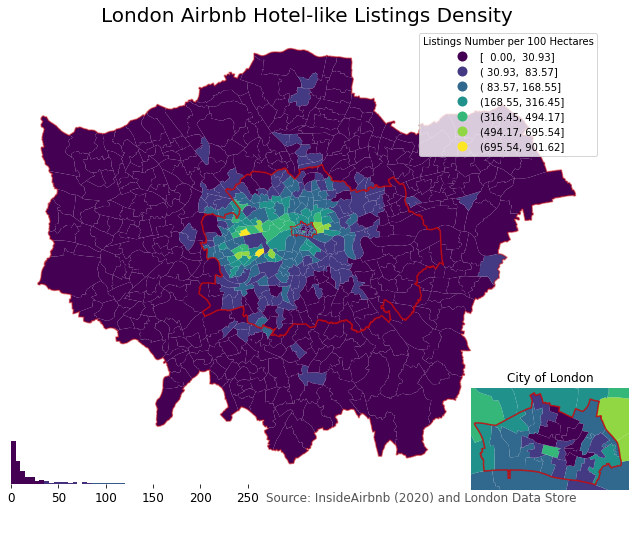

In [35]:
density()

***Proportion:***
    
The proportion of hotel-like listings was calculated in each ward as an indicator to see how hotel-like listings occupy the London area relative to homeshare listings. Through hotel-like listings proportion map (see figure below), the distribution of proportion is in a normal distribution, and the hotel-like listings in most areas account for 30% to 50% of the total listings. As for inner London, on the west of City of London, “hotels” dominate Airbnb's housing list. There are both very high and very low proportions in the wards of City of London. However, the proportion distribution of outer London is relatively scattered, though higher proportions arise in the west, northeast, and south.

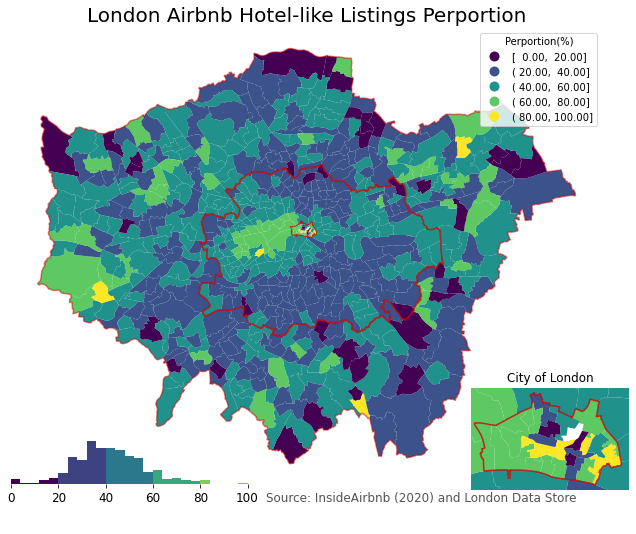

In [36]:
perportion()

## Conclusion
To expand the platform and increase revenue, Airbnb acquiesced in the existence of hotel business under the banner of “sharing economy”. These hotel runners are crowding out the market for those real home-sharers. In London, less than 20% of hotel runners account for nearly 50% of listings. Areas on the west of City of London suffered the most serious “hotel occupation” with both high hotel-like listings density and proportion. Moreover, hotel runners are easier to get the title of Superhost than home-sharers, while setting higher accommodation prices and generating more long-term vacant dwellings. 
## Suggestion
The government should make Airbnb live up to its name by requiring the company to introduce policies that are fairer to real home-sharers. For example, take into account the number of listings owned by a host in the requirement of becoming a Superhost instead of counting the total booking nights only. Moreover, certify those hosts with multiple listings, who are potentially trying to operate hotels in Airbnb and charge them lodging taxes just like a traditional hotel.


## Reference
Airbnb. (2020). _About Us._ Available at: https://news.airbnb.com/about-us/.

Alexandridis, G., Voutos, Y., Mylonas, P. and Caridakis, G. (2020). ‘A geolocation analytics-driven ontology for short-term leases: Inferring current sharing economy trends’. _Algorithms,_ 13 (3). doi: 10.3390/a13030059.

Ball, J., Arnett, G. and Franklin, W. (2014). ‘London’s buy-to-let landlords look to move in on spare room website Airbnb’. _The Guardian._ Available at: https://www.theguardian.com/technology/2014/jun/20/buy-to-let-landlords-leasing-properties-airbnb-uk.

Bivens, J. (2019). _The economic costs and benefits of Airbnb._ Available at: https://www.epi.org/publication/the-economic-costs-and-benefits-of-airbnb-no-reason-for-local-policymakers-to-let-airbnb-bypass-tax-or-regulatory-obligations/.

Hookway, N. (2008). ‘“Entering the blogosphere”: Some strategies for using blogs in social research’. _Qualitative Research,_ 8 (1), pp. 91–113. doi: 10.1177/1468794107085298.

Murray, C. (no date). _Disclaimers. Inside Airbnb._ Available at: http://insideairbnb.com/about.html#disclaimers.

Nieuwland, S. and van Melik, R. (2020). ‘Regulating Airbnb: how cities deal with perceived negative externalities of short-term rentals’. _Current Issues in Tourism._ Taylor & Francis, 23 (7), pp. 811–825. doi: 10.1080/13683500.2018.1504899.

Wachsmuth, D., Chaney, D., Kerrigan, D. Shillolo, A. and Basalaev-Binder, R. (2018), _The High Cost of Short-Term Rentals in New York City_. Urban Politics and Governance research group. McGill University. Available at: https://www.mcgill.ca/newsroom/files/newsroom/channels/attach/airbnb-report.pdf.

Wachsmuth, D. and Weisler, A. (2018). ‘Airbnb and the rent gap: Gentrification through the sharing economy’. _Environment and Planning A,_ 50 (6), pp. 1147–1170. doi: 10.1177/0308518X18778038.